In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np 
import pandas as pd

In [3]:
import torch
import torch.nn.functional as F
from torchvision import datasets,transforms
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
dataset = CIFAR10(root='data/', download=True, transform=ToTensor())
test_dataset = CIFAR10(root='data/', train=False, transform=ToTensor())

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/


In [6]:
val_size = 5000
train_size = len(dataset) - val_size

In [7]:
from torch.utils.data import random_split
val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [8]:
from torch.utils.data.dataloader import DataLoader

batch_size=64
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [9]:
@torch.no_grad()
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassification(nn.Module):
    def train_step(self, batch):
        images, labels = batch 
        if device == 'cuda':
            images, labels = images.to(device), labels.to(device)
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        accu = accuracy(out,labels)
        return loss,accu
    
    def validate(self, batch):
        images, labels = batch 
        if device == 'cuda':
            images, labels = images.to(device), labels.to(device)
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'Loss': loss.detach(), 'Accuracy': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['Loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['Accuracy'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'Loss': epoch_loss.item(), 'Accuracy': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch :",epoch + 1)
        print(f'Train Accuracy:{result["train_accuracy"]*100:.2f}% Validation Accuracy:{result["Accuracy"]*100:.2f}%')
        print(f'Train Loss:{result["train_loss"]:.4f} Validation Loss:{result["Loss"]:.4f}')

In [10]:
class CnnModel(ImageClassification):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            #alexnet
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            nn.BatchNorm2d(128),

            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            nn.BatchNorm2d(256),
            
            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [11]:
@torch.no_grad()
def evaluate(model, data_loader):
    model.eval()
    outputs = [model.validate(batch) for batch in data_loader]
    return model.validation_epoch_end(outputs)

def fit(model, train_loader, val_loader,epochs=10,learning_rate=0.001):
    best_valid = None
    history = []
    optimizer = torch.optim.Adam(model.parameters(), learning_rate,weight_decay=0.0005)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        train_accuracy = []
        for batch in tqdm(train_loader):
            loss,accu = model.train_step(batch)
            train_losses.append(loss)
            train_accuracy.append(accu)
            loss.backward()
            optimizer.step() 
            optimizer.zero_grad() # zero the parameter gradients
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_accuracy'] = torch.stack(train_accuracy).mean().item()
        model.epoch_end(epoch, result)
        if(best_valid == None or best_valid<result['Accuracy']):
            best_valid=result['Accuracy']
        history.append(result)
    return history

In [12]:
model=CnnModel()
model.to(device)

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dila

In [13]:
import timeit
start_time = timeit.default_timer()
history = fit(model, train_dl, val_dl)
elapsed = timeit.default_timer() - start_time
print("time elapsed in seconds" ,elapsed)

100%|██████████| 704/704 [00:17<00:00, 40.50it/s]


Epoch : 1
Train Accuracy:55.76% Validation Accuracy:65.96%
Train Loss:1.2274 Validation Loss:0.9524


100%|██████████| 704/704 [00:11<00:00, 59.78it/s]


Epoch : 2
Train Accuracy:72.85% Validation Accuracy:72.35%
Train Loss:0.7788 Validation Loss:0.8265


100%|██████████| 704/704 [00:11<00:00, 60.11it/s]


Epoch : 3
Train Accuracy:78.07% Validation Accuracy:75.65%
Train Loss:0.6306 Validation Loss:0.7239


100%|██████████| 704/704 [00:11<00:00, 59.90it/s]


Epoch : 4
Train Accuracy:81.96% Validation Accuracy:76.09%
Train Loss:0.5221 Validation Loss:0.7221


100%|██████████| 704/704 [00:11<00:00, 61.32it/s]


Epoch : 5
Train Accuracy:84.50% Validation Accuracy:79.96%
Train Loss:0.4482 Validation Loss:0.5948


100%|██████████| 704/704 [00:11<00:00, 60.21it/s]


Epoch : 6
Train Accuracy:86.55% Validation Accuracy:77.31%
Train Loss:0.3905 Validation Loss:0.6738


100%|██████████| 704/704 [00:11<00:00, 58.90it/s]


Epoch : 7
Train Accuracy:88.23% Validation Accuracy:79.69%
Train Loss:0.3412 Validation Loss:0.6473


100%|██████████| 704/704 [00:11<00:00, 61.64it/s]


Epoch : 8
Train Accuracy:89.48% Validation Accuracy:79.21%
Train Loss:0.3064 Validation Loss:0.6457


100%|██████████| 704/704 [00:11<00:00, 59.40it/s]


Epoch : 9
Train Accuracy:90.83% Validation Accuracy:79.61%
Train Loss:0.2648 Validation Loss:0.6494


100%|██████████| 704/704 [00:11<00:00, 61.02it/s]


Epoch : 10
Train Accuracy:91.71% Validation Accuracy:81.29%
Train Loss:0.2401 Validation Loss:0.5988
time elapsed in seconds 132.68114168300008


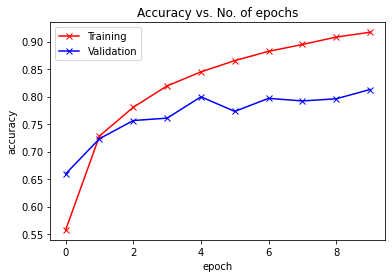

In [14]:
def plot_accuracies(history):
    Validation_accuracies = [x['Accuracy'] for x in history]
    Training_Accuracies = [x['train_accuracy'] for x in history]
    plt.plot(Training_Accuracies, '-rx')
    plt.plot(Validation_accuracies, '-bx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs');
plot_accuracies(history)

In [15]:
#test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())
test_loader = DataLoader(test_dataset, batch_size)
result = evaluate(model, test_loader)
print(f'Test Accuracy:{result["Accuracy"]*100:.2f}%')

Test Accuracy:82.60%
